# Recruit Restaurant Visitor Forecasting (Kuggle)

**Цель** : спрогнозировать посещаемость реторанов в Японии

**Данные** : данные предоставлены с нескольких площадок: Hot Pepper Gourmet (hpg) - система поиска ресторанов и онлайн заказы и AirRegi / Restaurant Board (air) - система контроля бронирования. Данные для обучения предоставлены с января 2016 по апрель 2017. 

**План**
1. Загрузка данных:
  - загрузка датасетов;
  - выявление дубликатов;
  - обработка выбросов;
  - соединение в итоговый датасет;
  - удаление ненужных признаков;
2. Исследование данных:
  - посмотреть распределение признаков, их описательные статистики (распределение, диперсия, средние значения и т.д.)
  - анализ корреляции количественных признаков;
3. Подготовка данных:
  - создание новых признаков;
  - кодирование категориальных признаков;
  - масштабирование количественных признаков;
4. Обучение различных моделей: 
  - подбор гиперпараметров;
  - оценка моделей по валидационной выборке и выбор лучшей модели.

Выбор метрики: MSE

In [1]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

from sklearn.model_selection import train_test_split

import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)

In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pylab as pltp

In [3]:
!pip install basemap


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Загрузка данных

In [4]:
#Загружу данные о резерве: время бронирования, время планируемого посещения, планируемое количество гостей

air_reserve = pd.read_csv('C:/Users/Latic/Documents/Data Science/Kaggle/Recruit Restaurant Visitor Forecasting/air_reserve.csv',
                         parse_dates = ['visit_datetime','reserve_datetime'])
hpg_reserve = pd.read_csv('C:/Users/Latic/Documents/Data Science/Kaggle/Recruit Restaurant Visitor Forecasting/hpg_reserve.csv',
                         parse_dates = ['visit_datetime','reserve_datetime'])
#Загружу данные о визите ресторана: дата посещения, количество гостей.
air_visit_data = pd.read_csv('C:/Users/Latic/Documents/Data Science/Kaggle/Recruit Restaurant Visitor Forecasting/air_visit_data.csv',
                         parse_dates = ['visit_date'])

#Данные о ресторане: кухня, раположение
air_store = pd.read_csv('C:/Users/Latic/Documents/Data Science/Kaggle/Recruit Restaurant Visitor Forecasting/air_store_info.csv')
hpg_store = pd.read_csv('C:/Users/Latic/Documents/Data Science/Kaggle/Recruit Restaurant Visitor Forecasting/hpg_store_info.csv')

#Ключ для реторанов, которые имеют данные в системе hpg и air
store_id_relation = pd.read_csv('C:/Users/Latic/Documents/Data Science/Kaggle/Recruit Restaurant Visitor Forecasting/store_id_relation.csv')

#Загружу информацию о праздниках в Японии
date_info = pd.read_csv('C:/Users/Latic/Documents/Data Science/Kaggle/Recruit Restaurant Visitor Forecasting/date_info.csv',
                        parse_dates = ['calendar_date'])

In [5]:
#Размер датасета
air_reserve.shape

(92378, 4)

In [6]:
# Проверю тип данных
air_reserve.dtypes

air_store_id                object
visit_datetime      datetime64[ns]
reserve_datetime    datetime64[ns]
reserve_visitors             int64
dtype: object

In [7]:
# Проверено пропуски
air_reserve.isnull().sum()

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [8]:
#Посмотрю период, за который предотавлены данные
a = air_reserve['reserve_datetime'].min().to_period('d')
b = air_reserve['reserve_datetime'].max().to_period('d')
c = air_reserve['visit_datetime'].min().to_period('d')
d = air_reserve['visit_datetime'].max().to_period('d')
print(f'Данные предотавлены за период:\nрезервировали места с {a} по {b}\гnланировать посетить ресторан с {c} по {d}')

Данные предотавлены за период:
резервировали места с 2016-01-01 по 2017-04-22\гnланировать посетить ресторан с 2016-01-01 по 2017-05-31


In [9]:
# Проверено на наличие дубликатов
air_reserve.duplicated().sum()

2770

Пустых строк, найдено 2 770 дубликатов, но это возможно слуайное совпадение цифр при бронировании. В датасете нет уникальных клюей бронирования, чтобы утверждать, что датасет содержит дублированные записи

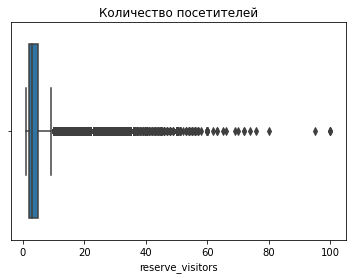

In [10]:
#Проверю на наличие выбросов
sns.boxplot(air_reserve['reserve_visitors'])
plt.title('Количество посетителей')
plt.show()

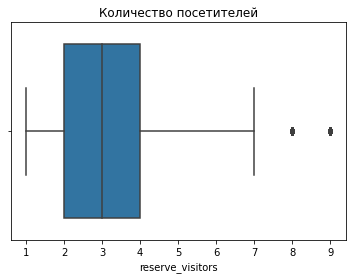

In [11]:
sns.boxplot(air_reserve[air_reserve['reserve_visitors']<10].reserve_visitors)
plt.title('Количество посетителей')
plt.show()

Обнаружено большое количество выбросов: посетители свыше 7 человек. Проверю, какое количество строк

In [12]:
num = len(air_reserve[air_reserve['reserve_visitors']>7])
print(f'Кол-во выбросов: {num}\nДоля выбросов: {round(num/len(air_reserve)*100,2)}%')

Кол-во выбросов: 11590
Доля выбросов: 12.55%


Доля выбросов составляет 12% от датасета - это много, поэтому не буду удалять, а заменю средним арифметическим по ресторану и месяцу резервирования

In [13]:
#напишу функцию для apply для вычисления среднего количества посетителей по реторану и месяцу резервирования
def avg_v(x):
    try:
        return round(air_reserve[(air_reserve['air_store_id']==x['air_store_id'])&
                       (air_reserve['reserve_visitors'].isna()==False)&
                             (air_reserve['reserve_datetime'].dt.month == x['reserve_datetime'].month)&
                            (air_reserve['reserve_visitors']<10)]['reserve_visitors'].mean())
    except:
        return x['reserve_visitors']


In [14]:
air_reserve['reserve_visitors'] = air_reserve.apply(lambda x: avg_v(x) if x['reserve_visitors']>7 else x['reserve_visitors'], axis = 1)

Исследую датасет с информацией о ресторанах

In [15]:
#Помотрю типы данных
air_store.dtypes

air_store_id       object
air_genre_name     object
air_area_name      object
latitude          float64
longitude         float64
dtype: object

In [16]:
#Проверю пропуски в датасете
air_store.isna().sum()

air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64

In [17]:
#Проверю на наличие дубликатов
air_store.duplicated().sum()

0

Исследую данные о визите ресторана с air_visit: id ресторана, дата посещения, количество гостей. Для ресторанов с hpg таких данных нет

In [18]:
#Проверю тип данных:
air_visit_data.dtypes

air_store_id            object
visit_date      datetime64[ns]
visitors                 int64
dtype: object

In [19]:
#Размер датасета
air_visit_data.shape

(252108, 3)

In [20]:
#Проверю наличие пропусков:
air_visit_data.isna().sum()

air_store_id    0
visit_date      0
visitors        0
dtype: int64

In [21]:
#Проверю наличие дубликатов
air_visit_data.duplicated().sum()

0

In [22]:
a = air_visit_data['visit_date'].min().to_period('d')
b = air_visit_data['visit_date'].max().to_period('d')
print(f'Период, за который предоставлена информация по посещению ресторанов с air с {a} по {b}')

Период, за который предоставлена информация по посещению ресторанов с air с 2016-01-01 по 2017-04-22


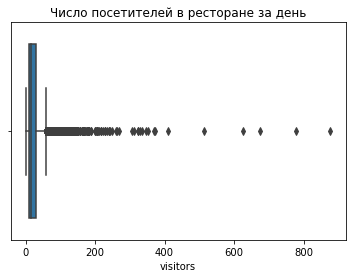

In [23]:
#Построю "ящик с усами" для анализ выбросов по целевому признаку количество посетителей за день
sns.boxplot(air_visit_data['visitors']).set_title('Число посетителей в ресторане за день')
plt.show()


In [24]:
air_visit_data.describe()

,visitors
count,252108.000000
mean,20.973761
std,16.757007
min,1.000000
25%,9.000000
50%,17.000000
75%,29.000000
max,877.000000


In [25]:
num = len(air_visit_data[air_visit_data['visitors']>29])
print(f'Кол-во выбросов: {num}\nДоля выбросов: {round(num/len(air_visit_data)*100,2)}%')

Кол-во выбросов: 61260
Доля выбросов: 24.3%


Доля выбросов составляет 24% от датасета - это много, поэтому не буду удалять, а заменю средним арифметическим по ресторану и месяцу посещения

In [26]:
#Вычислю среднее кол-во посетителей в день по ресторану и по месяцу
air_visit_data['month']=air_visit_data['visit_date'].dt.month
t_avg = air_visit_data[air_visit_data['visitors']<100].groupby(['air_store_id','month']).agg(mean = ('visitors','mean'))

In [27]:
#Присоединю к основной таблице вычисленное среднее значение
y = air_visit_data.merge(t_avg, on=['air_store_id',  'month'], how = 'left')

In [28]:
#Разделю основную таблицу на 2 части: с выбросами (больше 29 за день) и без выбросов. 
y_1 = y[y['visitors']<=29][['air_store_id','visit_date','visitors']]

In [29]:
#В таблице с выбросами эти выбросы заменю на столбец cо средними значениями
y_2 = y[y['visitors']>29][['air_store_id','visit_date','mean']].rename(columns={'mean':'visitors'})

In [30]:
#Соединю две части в одну результирующую таблицу
air_visit_data = pd.concat([y_1, y_2], axis=0)

Исследую данные с предоставленными праздниками в Японии

In [31]:
a = date_info['calendar_date'].min()
b = date_info['calendar_date'].max()
print(f'Период, за который предоставлена информация по праздникам в Японии с {a} по {b}')

Период, за который предоставлена информация по праздникам в Японии с 2016-01-01 00:00:00 по 2017-05-31 00:00:00


Объединю таблицы, предоставленные с системы air

In [32]:
air_total_data = air_reserve.merge(air_store, on = 'air_store_id', how = 'left')

In [33]:
air_total_data = air_total_data.merge(air_visit_data, left_on = ['air_store_id','visit_datetime'], 
                                      right_on=['air_store_id','visit_date'], how= 'outer' )

In [34]:
air_total_data = air_total_data.merge(store_id_relation, on= 'air_store_id', how = 'left')

Удалю строки  пропуcками в целевой переменной

In [35]:
air_total_data.isna().sum()

air_store_id             0
visit_datetime      251806
reserve_datetime    251806
reserve_visitors    251806
air_genre_name      251806
air_area_name       251806
latitude            251806
longitude           251806
visit_date           91980
visitors             91981
hpg_store_id        262053
dtype: int64

In [36]:
air_total_data = air_total_data[air_total_data['visitors'].isna()==False]

In [37]:
air_total_data.shape

(252203, 11)

Загружу данные о ресторанах с hpg

In [38]:
hpg_reserve.shape

(2000320, 4)

In [39]:
#Проверю типы данных
hpg_reserve.dtypes

hpg_store_id                object
visit_datetime      datetime64[ns]
reserve_datetime    datetime64[ns]
reserve_visitors             int64
dtype: object

In [40]:
#Проверю наличие пропусков
hpg_reserve.isna().sum()

hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [41]:
hpg_reserve.duplicated().sum()

16279

In [42]:
#Посмотрю период, за который предотавлены данные по резерву  hpg системы
a = hpg_reserve['reserve_datetime'].min().to_period('d')
b = hpg_reserve['reserve_datetime'].max().to_period('d')
c = hpg_reserve['visit_datetime'].min().to_period('d')
d = hpg_reserve['visit_datetime'].max().to_period('d')
print(f'Данные предотавлены за период:\nрезервировали места с {a} по {b}\nпосещали ресторан с {c} по {d}')

Данные предотавлены за период:
резервировали места с 2016-01-01 по 2017-04-22
посещали ресторан с 2016-01-01 по 2017-05-31


Исследую датасет с информацие о ресторанах с hpg

In [43]:
#Проверю наличие пропусков
hpg_store.isna().sum()

hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64

In [44]:
#Проверю наличие дубликатов
hpg_store.duplicated().sum()

0

Объединю все таблицы, предоставленные с hpg системы

In [45]:
hpg_total_data = hpg_reserve.merge(hpg_store, on='hpg_store_id', how = 'left')

In [46]:
total = air_total_data.merge(hpg_total_data, left_on = ['hpg_store_id','visit_date'], 
                             right_on = ['hpg_store_id','visit_datetime'], how = 'left' )

In [47]:
#Проверю наличие пропусков в итоговой таблице: найду долю пропуков в %

In [48]:
total.isna().mean()*100

air_store_id           0.000000
visit_datetime_x      99.841795
reserve_datetime_x    99.841795
reserve_visitors_x    99.841795
air_genre_name        99.841795
air_area_name         99.841795
latitude_x            99.841795
longitude_x           99.841795
visit_date             0.000000
visitors               0.000000
hpg_store_id          81.734231
visit_datetime_y      99.989294
reserve_datetime_y    99.989294
reserve_visitors_y    99.989294
hpg_genre_name        99.992466
hpg_area_name         99.992466
latitude_y            99.992466
longitude_y           99.992466
dtype: float64

In [49]:
#обработаю пропуски
total['air_genre_name'] = total['air_genre_name'].fillna(total['hpg_genre_name'])
total['air_area_name'] = total['air_area_name'].fillna(total['hpg_area_name'])
total['latitude_x'] = total['latitude_x'].fillna(total['latitude_y'])
total['longitude_x'] = total['longitude_x'].fillna(total['longitude_y'])

In [50]:
total.isna().mean()

air_store_id          0.000000
visit_datetime_x      0.998418
reserve_datetime_x    0.998418
reserve_visitors_x    0.998418
air_genre_name        0.998358
air_area_name         0.998358
latitude_x            0.998358
longitude_x           0.998358
visit_date            0.000000
visitors              0.000000
hpg_store_id          0.817342
visit_datetime_y      0.999893
reserve_datetime_y    0.999893
reserve_visitors_y    0.999893
hpg_genre_name        0.999925
hpg_area_name         0.999925
latitude_y            0.999925
longitude_y           0.999925
dtype: float64

In [51]:
date_info.dtypes

calendar_date    datetime64[ns]
day_of_week              object
holiday_flg               int64
dtype: object

In [52]:
total = total.merge(date_info, left_on = 'visit_date', right_on = 'calendar_date', how = 'left')

In [53]:
total.columns

Index(['air_store_id', 'visit_datetime_x', 'reserve_datetime_x',
       'reserve_visitors_x', 'air_genre_name', 'air_area_name', 'latitude_x',
       'longitude_x', 'visit_date', 'visitors', 'hpg_store_id',
       'visit_datetime_y', 'reserve_datetime_y', 'reserve_visitors_y',
       'hpg_genre_name', 'hpg_area_name', 'latitude_y', 'longitude_y',
       'calendar_date', 'day_of_week', 'holiday_flg'],
      dtype='object')

In [54]:
total=total.drop(['hpg_store_id','visit_datetime_x','visit_datetime_y', 'hpg_genre_name', 'hpg_area_name', 'longitude_y',
                 'latitude_y', 'calendar_date',], axis=1)

Посмотрю статистики в полученной итоговой таблице

In [55]:
total.describe()

,reserve_visitors_x,latitude_x,longitude_x,visitors,reserve_visitors_y,holiday_flg
count,399.000000,414.000000,414.000000,252204.000000,27.000000,252204.000000
mean,3.576441,37.632326,138.025647,18.088611,6.740741,0.050677
std,2.291243,3.728994,3.909922,11.452111,6.273219,0.219338
min,1.000000,33.319286,130.350764,1.000000,2.000000,0.000000
25%,2.000000,34.695124,135.197853,9.000000,2.000000,0.000000
50%,3.000000,35.661777,139.704051,17.000000,4.000000,0.000000
75%,4.000000,43.055460,141.340956,25.520000,9.500000,0.000000
max,24.000000,43.770635,142.364819,89.666667,27.000000,1.000000


Обработаю пропуски следующим образом: поставлю 0 в количественных признаках и '-' в категориальных

In [56]:
total[['reserve_visitors_x','reserve_visitors_y','latitude_x','longitude_x']] = total[['reserve_visitors_x',
                                                                                       'reserve_visitors_y',
                                                                                       'latitude_x','longitude_x']].fillna(0)
total[['air_genre_name','air_area_name']] = total[['air_genre_name','air_area_name']].fillna('-')

In [57]:
pd.DataFrame(total.corr())

,reserve_visitors_x,latitude_x,longitude_x,visitors,reserve_visitors_y,holiday_flg
reserve_visitors_x,1.000000,0.824100,0.827547,0.015276,0.041778,0.002858
latitude_x,0.824100,1.000000,0.996815,0.012223,0.151713,0.002797
longitude_x,0.827547,0.996815,1.000000,0.012126,0.146650,0.003088
visitors,0.015276,0.012223,0.012126,1.000000,0.001173,0.019529
reserve_visitors_y,0.041778,0.151713,0.146650,0.001173,1.000000,-0.001765
holiday_flg,0.002858,0.002797,0.003088,0.019529,-0.001765,1.000000


C:\Users\Latic\AppData\Local\Temp\ipykernel_5652\310176978.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(total.corr(), dtype=np.bool))


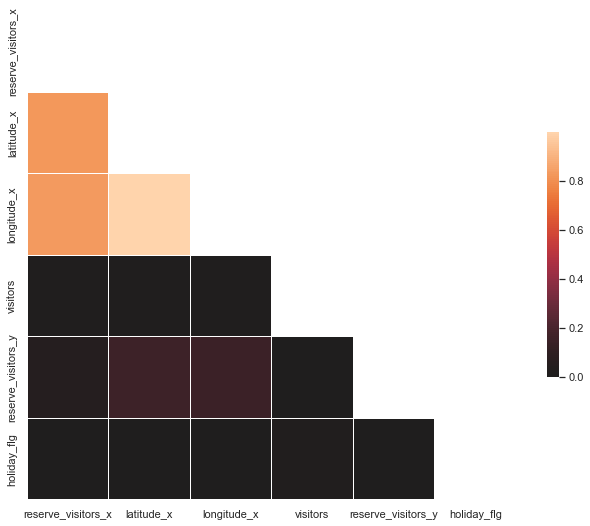

In [58]:
#Построю тепловую карту
sns.set(style = 'white')
mask = np.triu(np.ones_like(total.corr(), dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(total.corr(), mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Выявлена высокая корреляция признаков между широтой и долготой и количеством зарезервированных мест

#### Исследование данных и создание новых признаков

In [59]:
#Извлеку год, месяц и день в отдельные строки
total['year'] = total.visit_date.dt.year
total['month'] = total.visit_date.dt.month
total['day'] = total.visit_date.dt.day

In [60]:
#Поситаю среднее количество посетителей  месяц и потрою график
time_table = total[['visit_date','visitors']].set_index('visit_date')
avg_month = pd.DataFrame(time_table.resample('M').mean()).reset_index()
avg_month['month'] = avg_month['visit_date'].dt.month
avg_month['year'] = avg_month['visit_date'].dt.year
avg_month = avg_month.rename(columns={'visitors':'avg_visitors'})

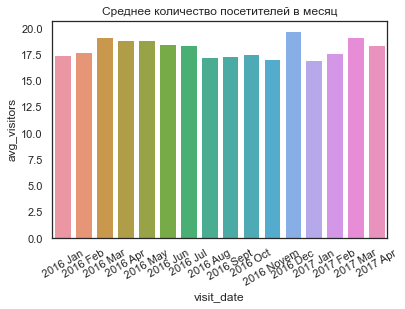

In [61]:
sns.barplot(x = 'visit_date', y = 'avg_visitors', data = avg_month).set_xticklabels(["2016 Jan", "2016 Feb", "2016 Mar", 
                                                                                 "2016 Apr", "2016 May", " 2016 Jun",
                                                                                 "2016 Jul", "2016 Aug", '2016 Sept',
                                                                                '2016 Oct','2016 Novem', '2016 Dec',
                                                                                '2017 Jan',"2017 Feb", "2017 Mar", 
                                                                                 "2017 Apr"],rotation=30)
sns.set(rc={'figure.figsize':(10,5)})
plt.title('Среднее количество посетителей в месяц')
plt.show()

По графику видно, что наиболее благоприятные месяцы для ресторанов - март, апрель, май. Зимой количество посетителей уменьшается.Только в  декабре в связи с празднкиами наблюдается высокий интерес к посещению ресторанов

In [62]:
# Добавлю в итоговую таблицу новый признак: среднее количество поcетителей в месяц
total = total.merge(avg_month[['month','year','avg_visitors']], on=['month','year'], how = 'left')

Проанализирую тренд и сезонность

In [63]:
t= total.groupby('visit_date').agg({'visitors':'sum'}).asfreq('D')

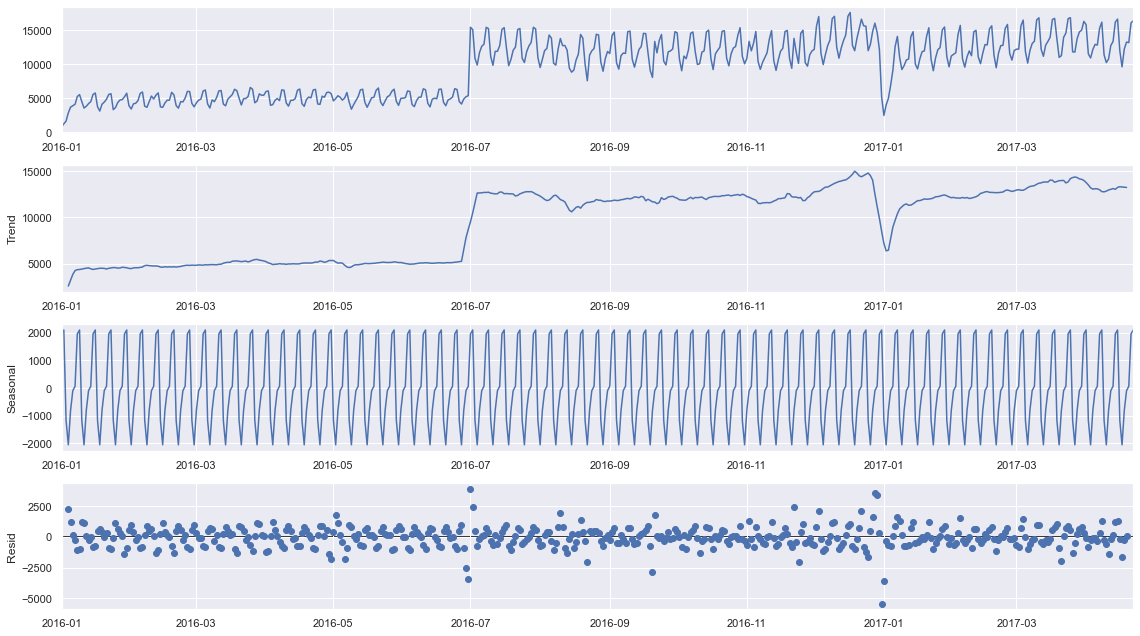

In [64]:
decomposed = seasonal_decompose(t)


rcParams['figure.figsize'] = 16, 9
decomposed.plot()

plt.show()

По графикам видно, что  с июля посещаемость реторанов резко увеличилась. Декабрь - самый посещаемый месяц (вероятно из-за корпоративов новогодних), в январе видим резкое снижение количества. Сезонности не выявлено.

Выберу три случайных ресторана: один из самых посещаемых, средний ресторан и непопулярный ресторан. По ним построю график посещения за период по месяцам, чтобы посмотреть закономерность

Посещение ресторанов за период с января 2016 по апрель 2017


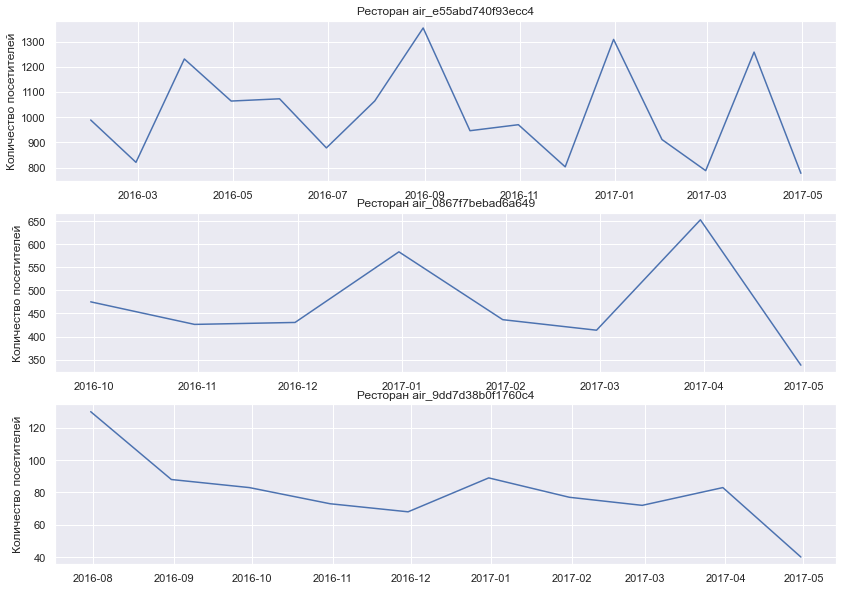

In [65]:
print('Посещение ресторанов за период с января 2016 по апрель 2017')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

ax1.plot(total[total['air_store_id']=='air_e55abd740f93ecc4'][['visit_date','visitors']].set_index('visit_date').resample('M').sum())
ax1.set(ylabel = 'Количество посетителей' )
ax1.set_title('Ресторан air_e55abd740f93ecc4')

ax2.plot(total[total['air_store_id']=='air_0867f7bebad6a649'][['visit_date','visitors']].set_index('visit_date').resample('M').sum())
ax2.set(ylabel = 'Количество посетителей' )
ax2.set_title('Ресторан air_0867f7bebad6a649')


ax3.plot(total[total['air_store_id']=='air_9dd7d38b0f1760c4'][['visit_date','visitors']].set_index('visit_date').resample('M').sum())
ax3.set(ylabel = 'Количество посетителей' )
ax3.set_title('Ресторан air_9dd7d38b0f1760c4')

plt.show()

По графикам видно, что данные по ресторанам предоставлены за разные промежутки времени. Видна закономерность поещения ресторанов: в декабре и апреле видны пики посещаемости ресторанов и снижение интереса к посещению ресторано в мае.

Выберу три месяца для анализа изменения количеcтва посетителей по дням недели: апрель, июль, ноябрь

In [66]:
avg_week = pd.DataFrame(time_table).reset_index()

In [67]:
avg_week['weekday'] = avg_week['visit_date'].dt.weekday
avg_week['month'] = avg_week['visit_date'].dt.month
avg_week['year'] = avg_week['visit_date'].dt.year

Посещение ресторанов по дням недели


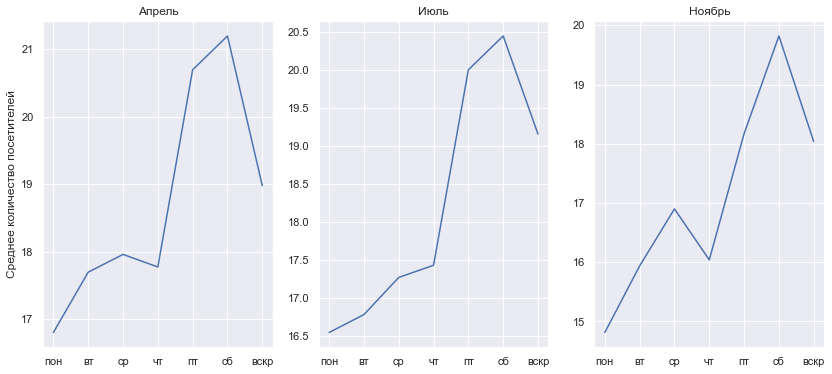

In [68]:
#Построю гитрограмму посещения реторанов по дням недели
print('Посещение ресторанов по дням недели')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

ax1.plot(avg_week[(avg_week['month']==4)&(avg_week['year']==2016)].groupby('weekday').agg({'visitors':['mean']}))
ax1.set(ylabel = 'Среднее количество посетителей' )
ax1.set_xticks([0,1,2,3,4,5,6])
ax1.set_xticklabels( ('пон','вт','ср','чт','пт','сб','вскр') )
ax1.set_title('Апрель')

ax2.plot(avg_week[(avg_week['month']==7)&(avg_week['year']==2016)].groupby('weekday').agg({'visitors':['mean']}))
ax2.set_xticks([0,1,2,3,4,5,6])
ax2.set_xticklabels( ('пон','вт','ср','чт','пт','сб','вскр') )
ax2.set_title('Июль')

ax3.plot(avg_week[(avg_week['month']==11)&(avg_week['year']==2016)].groupby('weekday').agg({'visitors':['mean']}))
ax3.set_xticks([0,1,2,3,4,5,6])
ax3.set_xticklabels( ('пон','вт','ср','чт','пт','сб','вскр') )
ax3.set_title('Ноябрь')

plt.show()

Вывод: на графиках видна закономерность плотности загруженности реторанов по дням недели: в понедельник наблюдается наименьшая загруженность, которая возрастает к выходным. Пик активности приходится на субботу и снижается к воскресенью

Посмотрю популярность ресторанов

In [69]:
store = pd.DataFrame(total.groupby('air_store_id')['visitors'].sum().sort_values(ascending = False))
store['perc, %'] = store['visitors'].apply(lambda x: round(x/sum(store['visitors'])*100, 2))

In [70]:
store

,visitors,"perc, %"
air_store_id,,
air_f26f36ec4dc5adb0,16867.910012,0.37
air_99157b6163835eec,16841.394598,0.37
air_d34c0861a2be94cb,16643.569860,0.36
air_e55abd740f93ecc4,16234.358068,0.36
air_eb120e6d384a17a8,16208.212649,0.36
...,...,...
air_5b704df317ed1962,715.680000,0.02
air_9a6f6e7f623003d2,714.871429,0.02
air_fdcfef8bd859f650,625.000000,0.01


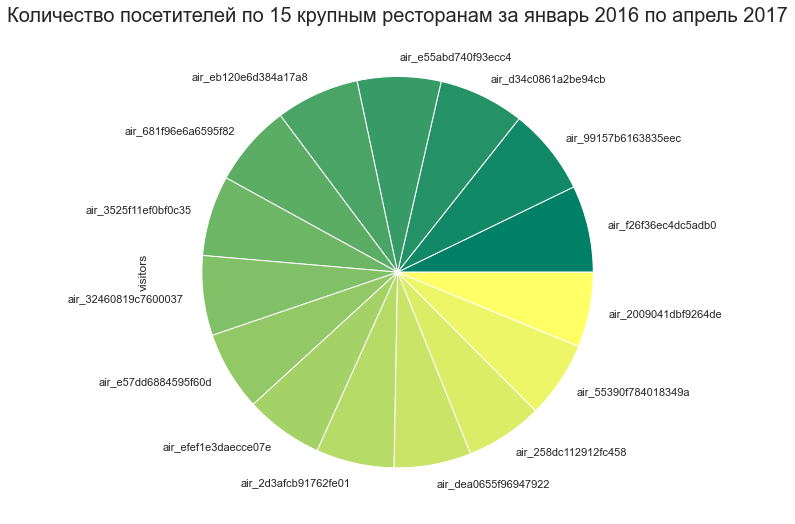

In [71]:
store.iloc[:15,0:1].plot(kind='pie', y='visitors', cmap='summer').get_legend().remove()
plt.title('Количество посетителей по 15 крупным ресторанам за январь 2016 по апрель 2017', fontsize=20)
plt.show()

Посмотрев из 829 реторанов наиболее 15 крупных, посещаемость данных ресторанов за год не сильно отличаетя друг от друга

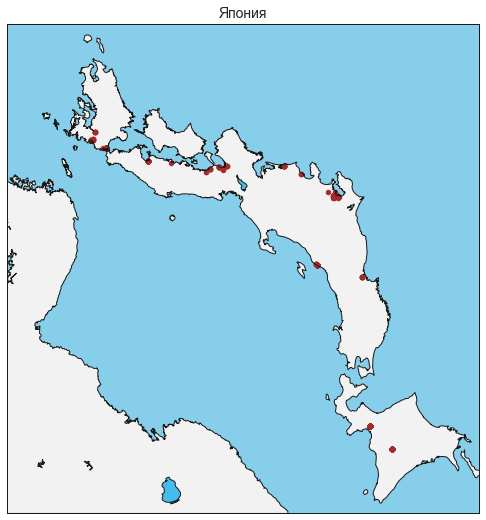

In [72]:
#Построю карту с указанием раположения ресторанов
m = Basemap(llcrnrlon=125,llcrnrlat=45,urcrnrlon=145,urcrnrlat=30,
             resolution='i', projection='tmerc' ,lat_0 = 35, lon_0 = 139)

 
x, y = m(total['longitude_x'],total['latitude_x'])
 
m.drawcoastlines()
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawmapboundary(fill_color='#87CEEB')

 
m.scatter(x,y,20,marker='o',color='#A52A2A')
plt.title("Япония", fontsize =14)
plt.show()

#### Посмотрю распределение видов кухни в ресторанах

In [73]:
y = pd.DataFrame(total[total['air_genre_name']!='-']['air_genre_name'].value_counts())
y ['perc %'] = round(y['air_genre_name']/sum(y['air_genre_name'])*100)
y

,air_genre_name,perc %
Dining bar,115,28.0
Izakaya,105,25.0
Italian/French,70,17.0
Cafe/Sweets,43,10.0
Bar/Cocktail,21,5.0
Japanese food,15,4.0
Karaoke/Party,13,3.0
Yakiniku/Korean food,10,2.0
Western food,5,1.0
International cuisine,5,1.0


Наиболее популярная кухня в предоставленных реторанах: идзакая (тип японского питейного заведения). Намного отстает по поулярности: рестораны с итальянской и французкой кухнями. Намного меньше в выборке представлены азиаткая кухня, караоке, кафе

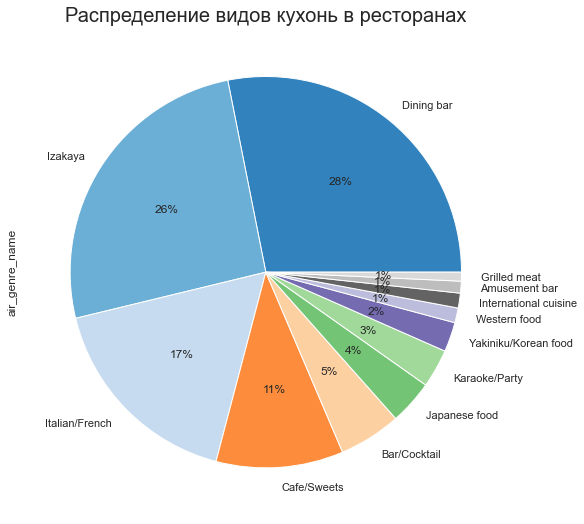

In [74]:
y[y['perc %']>0]['air_genre_name'].plot(kind='pie', subplots=True, cmap='tab20c',  autopct='%1.0f%%')
plt.title('Распределение видов кухонь в ресторанах', fontsize=20)
plt.show()

In [75]:
#Закодирую номинативные признаки
encoder = OrdinalEncoder()
total [['air_genre_name','air_area_name', 'day_of_week','air_store_id',]] = encoder.fit_transform(total[['air_genre_name','air_area_name','day_of_week','air_store_id']])

In [76]:
#Создам "отстающие значения" временного ряда
total['lag_1'] = total['visitors'].shift(1)
total['lag_2'] = total['visitors'].shift(2)
total['lag_3'] = total['visitors'].shift(3)
total['lag_4'] = total['visitors'].shift(4)


In [77]:
#Создам скользящее среднее
total['rolling_mean'] = total['visitors'].rolling(5).mean()
#Такой признак учитывает текущее значение, поэтому смещю значение на один
total['rolling_mean'] = total['rolling_mean'].shift(1)
total = total.fillna(0)

In [78]:
total

,air_store_id,reserve_datetime_x,reserve_visitors_x,air_genre_name,air_area_name,latitude_x,longitude_x,visit_date,visitors,reserve_datetime_y,...,holiday_flg,year,month,day,avg_visitors,lag_1,lag_2,lag_3,lag_4,rolling_mean
0,147.0,2016-01-02 13:00:00,4.0,9.0,27.0,34.975140,138.383243,2016-01-03,30.940000,0,...,1,2016,1,3,17.460249,0.000000,0.000000,0.000000,0.000000,0.000000
1,147.0,2016-01-07 19:00:00,6.0,9.0,27.0,34.975140,138.383243,2016-01-09,30.940000,0,...,0,2016,1,9,17.460249,30.940000,0.000000,0.000000,0.000000,0.000000
2,711.0,2016-01-09 21:00:00,1.0,5.0,42.0,34.676231,135.486059,2016-01-10,21.000000,0,...,0,2016,1,10,17.460249,30.940000,30.940000,0.000000,0.000000,0.000000
3,711.0,2016-01-17 00:00:00,1.0,5.0,42.0,34.676231,135.486059,2016-01-17,13.000000,0,...,0,2016,1,17,17.460249,21.000000,30.940000,30.940000,0.000000,0.000000
4,711.0,2016-01-24 00:00:00,1.0,5.0,42.0,34.676231,135.486059,2016-01-24,13.000000,0,...,0,2016,1,24,17.460249,13.000000,21.000000,30.940000,30.940000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252199,648.0,0,0.0,0.0,0.0,0.000000,0.000000,2016-12-22,14.480000,0,...,0,2016,12,22,19.731950,15.737705,15.561404,13.021739,15.366667,15.010836
252200,648.0,0,0.0,0.0,0.0,0.000000,0.000000,2017-02-10,14.384615,0,...,0,2017,2,10,17.652060,14.480000,15.737705,15.561404,13.021739,14.833503
252201,648.0,0,0.0,0.0,0.0,0.000000,0.000000,2017-03-11,17.468750,0,...,0,2017,3,11,19.210511,14.384615,14.480000,15.737705,15.561404,14.637093
252202,648.0,0,0.0,0.0,0.0,0.000000,0.000000,2017-03-17,17.468750,0,...,0,2017,3,17,19.210511,17.468750,14.384615,14.480000,15.737705,15.526495


### Обучение

Подготовлю датасет. Разделю на три части:тренировочную, валидационную и тестовую выборки

In [79]:
#Выделю признаки и таргет в отдельные таблицы
y = total['visitors']
x = total.drop(['visitors','visit_date','reserve_datetime_x','reserve_datetime_y'], axis =1)

In [80]:
#разделю датасет на три части
train_x, test_x, train_y, test_y = train_test_split(x,y, shuffle=False, test_size=0.2)
train_x, val_x,train_y, val_y = train_test_split(train_x,train_y, shuffle=False, test_size=0.2)

In [81]:
#Стандартизация данных
scaler= StandardScaler()
scaler.fit(train_x)
train_x_st, test_x_st, val_x_st = pd.DataFrame(scaler.transform(train_x)), pd.DataFrame(scaler.transform(test_x)), pd.DataFrame(scaler.transform(val_x))

In [111]:
#создам результирующую таблицу, куда буду добавлять оценки модели на валидационной выборке, чтобы выбрать лучшую 
result = pd.DataFrame(columns=['модель','MSE', 'время обучения'])

#### LinearRegression

In [112]:
#Обучу модель линейной регрессии
l = LinearRegression()

start = time.time()
l.fit(train_x,train_y)
stop = time.time()

In [113]:
#Найду оценку модели на валидацонной выборке
pred_y = l.predict(val_x)
mse_l = mean_squared_error(val_y, pred_y)

In [114]:
result.loc[len(result.index)] = ['LinearRegression', mse_l, stop-start ]

#### Ridge

In [115]:
#подбор гиперпараметров
l_ridge = GridSearchCV(Ridge(), [{'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}],scoring = 'neg_mean_squared_error')

start = time.time()
model_ridge = l_ridge.fit(train_x, train_y)
stop = time.time()

In [116]:
#Найду оценку модели на валидацонной выборке
pred_y = model_ridge.predict(val_x)
mse_r = mean_squared_error(val_y, pred_y)

In [117]:
result.loc[len(result.index)] = ['Ridge', mse_r, stop-start ]

#### Lasso

In [118]:
#подбор гиперпараметров
l_lasso = GridSearchCV(Lasso(), [{'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}], scoring = 'neg_mean_squared_error')

start = time.time()
model_lasso = l_lasso.fit(train_x, train_y)
stop = time.time()

In [119]:
#Найду оценку модели на валидацонной выборке
pred_y = model_lasso.predict(val_x)
mse_r = mean_squared_error(val_y, pred_y)

In [120]:
result.loc[len(result.index)] = ['Lasso', mse_r, stop-start ]

#### XGBRegressor

In [93]:
#подбор гиперпараметров
XGB = GridSearchCV(XGBRegressor(), [{'max_depth': [3, 4],
                                   'n_estimators': [ 150, 500],
                                   'learning_rate': [0.1, 0.2]}],scoring = 'neg_mean_squared_error')
#обучение на тренировочной выборке
start = time.time()
model_XGB = XGB.fit(train_x, train_y)
stop = time.time()

In [122]:
#Найду оценку модели на валидацонной выборке
pred_y = model_XGB.predict(val_x)
mse_r = mean_squared_error(val_y, pred_y)

In [123]:
result.loc[len(result.index)] = ['XGBRegressor', mse_r, stop-start ]

Выведу результирующую таблицу

In [124]:
result

,модель,MSE,время обучения
0,LinearRegression,40.667903,0.192975
1,Ridge,40.668580,6.850198
2,Lasso,40.700419,23.157315
3,XGBRegressor,71.055790,23.157315


Наилуший результат показала линейная регрессия и по метрике и по времени

Сделаю предказание на тестовой выборке

In [125]:
pred_test_y = l.predict(test_x)
mean_squared_error(test_y, pred_test_y)

36.577538117652686

MSE на тестовой выборке 36.5775

In [129]:
submission = pd.read_csv('C:/Users/Latic/Documents/Data Science/Kaggle/Recruit Restaurant Visitor Forecasting/sample_submission.csv', sep="_")

In [130]:
submission

id,visitors
air 00a91d42b08b08d9  2017-04-23,0
    00a91d42b08b08d9  2017-04-24,0
    00a91d42b08b08d9  2017-04-25,0
    00a91d42b08b08d9  2017-04-26,0
    00a91d42b08b08d9  2017-04-27,0
...                            ...
    fff68b929994bfbd  2017-05-27,0
    fff68b929994bfbd  2017-05-28,0
    fff68b929994bfbd  2017-05-29,0
    fff68b929994bfbd  2017-05-30,0
    fff68b929994bfbd  2017-05-31,0

[32019 rows x 1 columns]